In [1]:
pwd

'/mnt/md0/isshamie/Projects/Mito_Trace/workflow/notebooks/variant_types'

In [2]:
#dat_indir="data/CHIP_april08_2021/MTblacklist/chrM/pseudo/minC200_minAF0.01/numC100000_ispropFalse/"
#vars_type_f = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/anno_variants/varsType.tsv"
# mult_dir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/"
# outdir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/vars_type/"
# sample_names="Control,Flt3l,Input"

#indir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_init"
# outdir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_init/variantTypes/"
# N_DONORS=2
#DONOR = 1

# indir = "/data/Mito_Trace/output/pipeline/v04/CHIP_b2/InputOnly/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_prefilterMerge_impute"
# outdir = "/data/Mito_Trace/output/pipeline/v04/CHIP_b2/InputOnly/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_prefilterMerge_impute/variantTypes"


indir = "/data/Mito_Trace/output/pipeline/v04/CHIP_Input_nameFix_april08_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_prefilterMerge_impute"
outdir = "/data/Mito_Trace/output/pipeline/v04/CHIP_Input_nameFix_april08_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_prefilterMerge_impute/variantTypes"

verbose=False

In [3]:
from os.path import join, exists, dirname
import os
from glob import glob
import pickle
import mplh.cluster_help as ch
import os
import vireoSNP
import numpy as np
from scipy import sparse
from scipy.io import mmread
import matplotlib.pyplot as plt
from scipy.stats import hypergeom
print(vireoSNP.__version__)

import pandas as pd
import seaborn as sns
from vireoSNP import Vireo
np.set_printoptions(formatter={'float': lambda x: format(x, '.5f')})

from src.external.pyvenn import venn

%load_ext autoreload
%autoreload 2
import src.utils.variant_utils as vu
from src.utils.data_io import wrap_load_mtx_df

fig_utils from mplh
0.5.6


In [4]:
cells_meta = pd.read_csv(join(dirname(indir), "cells_meta.tsv"), sep="\t")
#cells_meta["lineage"] = cells_meta.apply(lambda x: f'{x["donor"]}_{x["lineage"]}', axis=1)
cells_meta["donor"] = cells_meta["donor"].astype('Int32')
cells_meta = cells_meta.dropna(subset=["donor"])
cells_meta

,index,ID,raw ID,new index,condition,donor,donor_index
0,0,AAACGAAAGGAAACTT-1_Input,AAACGAAAGGAAACTT-1,1,Input,1,1.0
1,1,AAACGAAGTCCAAGAG-1_Input,AAACGAAGTCCAAGAG-1,2,Input,4,1.0
2,2,AAACGAAGTCCGAGCT-1_Input,AAACGAAGTCCGAGCT-1,3,Input,3,1.0
4,4,AAACGAAGTTTGAAGA-1_Input,AAACGAAGTTTGAAGA-1,5,Input,1,2.0
5,5,AAACGAATCCCAGTAA-1_Input,AAACGAATCCCAGTAA-1,6,Input,0,1.0
...,...,...,...,...,...,...,...
4683,4683,TTGTTCAAGTGAATAC-1_Flt3l,TTGTTCAAGTGAATAC-1,4684,Flt3l,2,1128.0
4684,4684,TTTACGTCAAGCCAGA-1_Flt3l,TTTACGTCAAGCCAGA-1,4685,Flt3l,1,767.0
4685,4685,TTTGAGGAGTCTCGAT-1_Flt3l,TTTGAGGAGTCTCGAT-1,4686,Flt3l,3,818.0
4686,4686,TTTGAGGGTTGCAGAG-1_Flt3l,TTTGAGGGTTGCAGAG-1,4687,Flt3l,4,767.0


## Loop through donor af matrix

In [5]:
def get_high_variants(df, thresh, pct_thresh):
    """ Remove rows that have an average higher than threshold

    :param df:
    :param thresh:
    :return:
    """
    n_pct = pct_thresh*df.shape[0]
    #print('n_pct', n_pct)
    #print(df.head())
    return df.loc[:,((df>thresh).sum()>n_pct)].columns.values


# g = sns.clustermap(AF_df.loc[:, donor_vars])
# g.fig.savefig(fname=join(outdir, f"donor_variants.pdf"))
#plt.savefig(join(outdir, "donor_vars.png"))

In [6]:
all_af = []
all_dp = []
all_donor_vars = {}
all_vcf = []
for d, val in cells_meta.groupby("donor"):
    af_indir = join(indir, f"donor{d}")
    curr_af = pd.read_csv(join(af_indir, "af.tsv"), index_col=0, sep="\t").fillna(0)
    curr_af = curr_af.fillna(0)
    all_af.append(curr_af)
    all_dp.append(pd.read_csv(join(af_indir, "dp.tsv"), index_col=0, sep="\t").fillna(0))
    donor_vars = get_high_variants(all_af[-1], thresh=0.8, pct_thresh=0.9)
    all_donor_vars[d] = donor_vars
    print(f"number of donor vars: {len(donor_vars)}")
    all_vcf.append(pd.read_csv(join(af_indir, "cellSNP.base.vcf"),sep="\t"))
    all_vcf[-1]["donor"] = d
    all_vcf[-1] 
all_af = pd.concat(all_af, axis=0)
all_dp = pd.concat(all_dp, axis=0)

assert(not all_af.index.duplicated().any())
all_af

number of donor vars: 0
number of donor vars: 1
number of donor vars: 0
number of donor vars: 0
number of donor vars: 0


,709A,930A,1888A,1949A,2514A,3010A,3552A,3630A,3655A,3820A,...,3144G,6047G,2291T,5817T,16519C,515G,290T,11719A,310C,2706G
Cell,,,,,,,,,,,,,,,,,,,,,
AAACGAATCCCAGTAA-1_Input,0.0,0.0,0.011111,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.009756,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACGAATCGTGAACT-1_Input,0.0,0.0,0.000000,0.0,0.000000,0.0,0.011574,0.004090,0.003817,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACTCGAGGTACACG-1_Input,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.006993,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACTCGCAAGACACG-1_Input,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.005952,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACTGCAGGATGTAT-1_Input,0.0,0.0,0.000000,0.0,0.013575,0.0,0.000000,0.005882,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTAGCTTAGGTCGGTA-1_Flt3l,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.795699,0.0
TTCGTTAGTATTCTTC-1_Flt3l,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.861148,0.0
TTGCCCAGTTATAGAG-1_Flt3l,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.886486,0.0


In [7]:
all_vcf_df = pd.concat(all_vcf).drop("index", axis=1)
all_vcf_df = all_vcf_df[~(all_vcf_df.duplicated())].reset_index(drop=True)
all_vcf_df

,#CHROM,POS,REF,ALT,donor
0,MT,709,G709,A,0
1,MT,930,G930,A,0
2,MT,1888,G1888,A,0
3,MT,1949,G1949,A,0
4,MT,2514,C2514,A,0
...,...,...,...,...,...
118,MT,3106,C3106,A,4
119,MT,8118,G8118,A,4
120,MT,11719,G11719,A,4
121,MT,310,T310,C,4


In [8]:
all_vcf_df["REF"] = all_vcf_df.apply(lambda x: x["REF"][0], axis=1)
all_vcf_df['ID'] = all_vcf_df.fillna("N").apply(lambda x: str(x["POS"]) + x['REF']+">"+x['ALT'], axis=1)
#all_vcf_df = all_vcf_df.set_index("ID")

In [9]:
variant_df = vu.type_of_variants(set(all_vcf_df["ID"].values))
variant_df["ID"] = variant_df.apply(lambda x: f'{x["position"]}{x["alt"]}', axis=1)
variant_df


,position,ref,alt,variant type,variant change,ID
4806T>A,4806,T,A,Transversion,T>A,4806A
4100T>A,4100,T,A,Transversion,T>A,4100A
12297T>C,12297,T,C,Transition,T>C,12297C
11382C>A,11382,C,A,Transversion,C>A,11382A
7697G>A,7697,G,A,Transition,G>A,7697A
...,...,...,...,...,...,...
16298T>C,16298,T,C,Transition,T>C,16298C
4216T>C,4216,T,C,Transition,T>C,4216C
7689G>A,7689,G,A,Transition,G>A,7689A
11914G>A,11914,G,A,Transition,G>A,11914A


In [10]:
all_vcf_df["variant type"] = all_vcf_df.apply(lambda x: variant_df.loc[x['ID'], "variant type"], axis=1)
all_vcf_df["variant"] = all_vcf_df.apply(lambda x: variant_df.loc[x['ID'], "ID"], axis=1)
all_vcf_df

,#CHROM,POS,REF,ALT,donor,ID,variant type,variant
0,MT,709,G,A,0,709G>A,Transition,709A
1,MT,930,G,A,0,930G>A,Transition,930A
2,MT,1888,G,A,0,1888G>A,Transition,1888A
3,MT,1949,G,A,0,1949G>A,Transition,1949A
4,MT,2514,C,A,0,2514C>A,Transversion,2514A
...,...,...,...,...,...,...,...,...
118,MT,3106,C,A,4,3106C>A,Transversion,3106A
119,MT,8118,G,A,4,8118G>A,Transition,8118A
120,MT,11719,G,A,4,11719G>A,Transition,11719A
121,MT,310,T,C,4,310T>C,Transition,310C


In [11]:
all_vcf_df['is_donor_var'] = all_vcf_df.apply(lambda x: x["variant"] in all_donor_vars[x["donor"]], axis=1)
donor_spec_vcf_df = all_vcf_df[all_vcf_df['is_donor_var']].copy()


In [12]:
variant_df = variant_df.set_index("ID")

## A. Countplot of donor variants variant types 

In [13]:
donor_spec_vcf_df

,#CHROM,POS,REF,ALT,donor,ID,variant type,variant,is_donor_var
109,MT,16296,C,T,1,16296C>T,Transition,16296T,True


In [14]:
if len(donor_spec_vcf_df) > 1:
    g = sns.FacetGrid(data=donor_spec_vcf_df, col="donor", height=4)
    g.map_dataframe(sns.countplot, x="variant type")
    g.fig.savefig(join(outdir, "variant_type_donor_vars.pdf"), bbox_inches='tight', pad_inches=0.5)
# elif len(donor_spec_vcf_df) == 1:   
#     f = plt.figure()
#     sns.heatmap(donor_spec_vcf_df)
#     plt.savefig(join(outdir, "variant_type_donor_vars.pdf"), bbox_inches='tight', pad_inches=0.5)
    

In [15]:
all_vcf_df

,#CHROM,POS,REF,ALT,donor,ID,variant type,variant,is_donor_var
0,MT,709,G,A,0,709G>A,Transition,709A,False
1,MT,930,G,A,0,930G>A,Transition,930A,False
2,MT,1888,G,A,0,1888G>A,Transition,1888A,False
3,MT,1949,G,A,0,1949G>A,Transition,1949A,False
4,MT,2514,C,A,0,2514C>A,Transversion,2514A,False
...,...,...,...,...,...,...,...,...,...
118,MT,3106,C,A,4,3106C>A,Transversion,3106A,False
119,MT,8118,G,A,4,8118G>A,Transition,8118A,False
120,MT,11719,G,A,4,11719G>A,Transition,11719A,False
121,MT,310,T,C,4,310T>C,Transition,310C,False


In [16]:
# g = sns.FacetGrid(data=all_vcf_df, col="donor")
# g.map_dataframe(sns.countplot, x="variant type")
# g

In [17]:
all_vcf_df.groupby(["donor", "variant type"]).size()

donor  variant type
0      Transition      67
       Transversion    26
1      Transition      11
       Transversion     6
2      Transition       5
       Transversion     2
3      Transversion     1
4      Transition       4
       Transversion     1
dtype: int64

# B. Violinplot across conditions and donors of donor vars (colored by transition/transversion)

In [18]:
long_all_af = pd.merge(all_af, cells_meta.set_index("ID")[["condition", "donor"]], left_index=True, right_index=True).reset_index().melt(id_vars=["index", "condition", "donor"], var_name="Variant", value_name="AF")
long_all_af

long_all_af["variant type"] = long_all_af["Variant"].apply(lambda x: variant_df.loc[x, "variant type"])
long_all_af


,index,condition,donor,Variant,AF,variant type
0,AAACGAATCCCAGTAA-1_Input,Input,0,709A,0.0,Transition
1,AAACGAATCGTGAACT-1_Input,Input,0,709A,0.0,Transition
2,AAACTCGAGGTACACG-1_Input,Input,0,709A,0.0,Transition
3,AAACTCGCAAGACACG-1_Input,Input,0,709A,0.0,Transition
4,AAACTGCAGGATGTAT-1_Input,Input,0,709A,0.0,Transition
...,...,...,...,...,...,...
161387,TTAGCTTAGGTCGGTA-1_Flt3l,Flt3l,4,2706G,0.0,Transition
161388,TTCGTTAGTATTCTTC-1_Flt3l,Flt3l,4,2706G,0.0,Transition
161389,TTGCCCAGTTATAGAG-1_Flt3l,Flt3l,4,2706G,0.0,Transition
161390,TTGCGAAAGACCGCAA-1_Flt3l,Flt3l,4,2706G,0.0,Transition


In [19]:
# g = sns.FacetGrid(data=long_all_af, col="donor", height=4)
# g.map_dataframe(sns.pointplot, y="AF", x="condition", hue="variant type", hue_order=["Transition", "Transversion"])
# plt.legend()
# g.fig.savefig(join(outdir, "variant_type_all_vars.pdf"), bbox_inches='tight', pad_inches=0.5)

# C. Transition vs transversion AF overall per donor

FileNotFoundError: [Errno 2] No such file or directory: '/data/Mito_Trace/output/pipeline/v04/CHIP_Input_nameFix_april08_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_prefilterMerge_impute/variantTypes/variant_af_all_vars_violin.pdf'

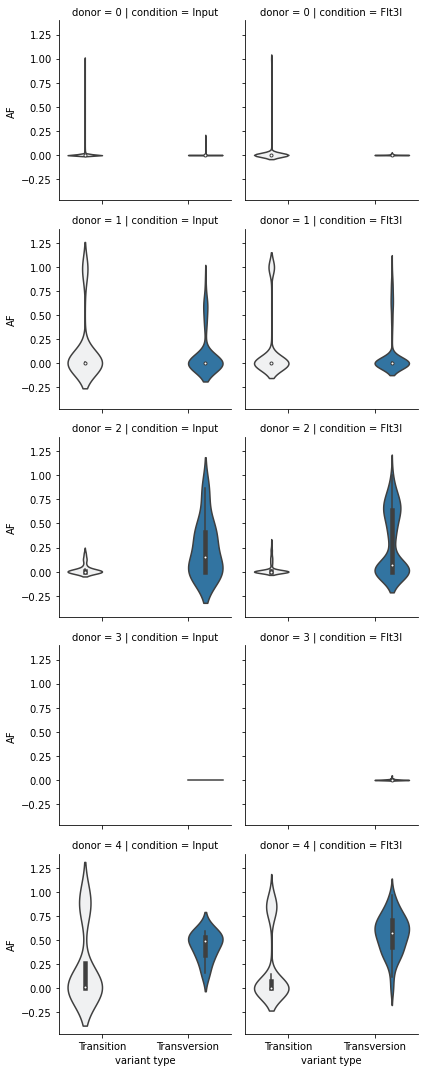

In [20]:
g = sns.FacetGrid(data=long_all_af, row="donor", col="condition", 
                  )
g.map_dataframe(sns.violinplot, y="AF", x= "variant type", hue="variant type", hue_order=["Transition", "Transversion"])
g.fig.savefig(join(outdir, "variant_af_all_vars_violin.pdf"), bbox_inches='tight', pad_inches=0.5)
plt.legend()

In [ ]:
don_vars = []
for x in all_donor_vars:
    don_vars.extend(all_donor_vars[x])
don_vars = set(don_vars)
don_vars

In [ ]:
if len(don_vars) > 0:
    long_don_af = pd.merge(all_af.loc[:,all_af.columns.isin(don_vars)], cells_meta.set_index("ID")[["condition", "donor"]], left_index=True, right_index=True).reset_index().melt(id_vars=["index", "condition", "donor"], var_name="Variant", value_name="AF")
    long_don_af
    long_don_af = long_don_af[long_don_af["Variant"].isin(don_vars)]
    long_don_af["variant type"] = long_don_af["Variant"].apply(lambda x: variant_df.loc[x, "variant type"])
    long_don_af


    f, ax = plt.subplots(figsize=(16,16), nrows=len(all_donor_vars),ncols=2, sharex=False, sharey=False)#squeeze=True)
    for d, val in long_don_af.groupby("donor"):
        val = val[val["Variant"].isin(all_donor_vars[d])]
        #g = sns.FacetGrid(data=long_don_af, row="donor", col="condition")
        #g.map_dataframe(sns.violinplot, y="AF", x= "variant type", hue="variant type", hue_order=["Transition", "Transversion"])

        sns.violinplot(data=val, y="AF", x= "variant type", hue="variant type", hue_order=["Transition", "Transversion"], ax=ax[d,0])
        sns.violinplot(data=val, y="AF", x= "condition", hue="variant type", hue_order=["Transition", "Transversion"], ax=ax[d,1])
    plt.legend()
    plt.savefig(join(outdir, "variant_af_donor_vars_violin.pdf"), bbox_inches='tight', pad_inches=0.5)